In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

- *Preparação dos dados (medições de vento)*

In [24]:
# Ler arquivo de medições de velocidade do vento
df_vento = pd.read_csv(r"data\dados_vel_vento_medido.csv", index_col="TS",parse_dates=True)

# Renomear colunas para nomes mais sugestivos
df_vento = df_vento.rename(columns={"WSP_MEAN_2":"WSP"})

# Converter para dados mensais
df_vento_mensal = df_vento.resample("MS").mean()

# Checagem de dados
print(df_vento_mensal.info())
print(df_vento_mensal.isna().sum())
# Visualizar dados
df_vento_mensal

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 2018-10-01 to 2025-05-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WSP     80 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB
None
WSP    0
dtype: int64


,WSP
TS,
2018-10-01,9.695691
2018-11-01,9.791519
2018-12-01,8.465055
2019-01-01,7.910039
2019-02-01,6.769769
...,...
2025-01-01,7.195318
2025-02-01,7.535152
2025-03-01,6.888068


- *Preparação dos dados (reanálises)*

In [25]:
# Ler arquivo de dados meteorológicos diversos de reanálises
df_meteo = pd.read_csv(r"data\dados_meteorologicos_reanalise_ERA5.csv", skiprows=3,index_col="time",parse_dates=True)

# Converter para dados mensais
df_meteo_mensal = df_meteo.resample("MS").mean()

# Checagem de dados

print(df_meteo_mensal.info())
print(df_meteo_mensal.isna().sum())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413 entries, 1991-01-01 to 2025-05-01
Freq: MS
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   temperature_2m (°C)         413 non-null    float64
 1   relative_humidity_2m (%)    413 non-null    float64
 2   surface_pressure (hPa)      413 non-null    float64
 3   cloud_cover (%)             413 non-null    float64
 4   wind_speed_100m (m/s)       413 non-null    float64
 5   shortwave_radiation (W/m²)  413 non-null    float64
 6   boundary_layer_height (m)   408 non-null    float64
 7   wind_gusts_10m (m/s)        413 non-null    float64
dtypes: float64(8)
memory usage: 29.0 KB
None
temperature_2m (°C)           0
relative_humidity_2m (%)      0
surface_pressure (hPa)        0
cloud_cover (%)               0
wind_speed_100m (m/s)         0
shortwave_radiation (W/m²)    0
boundary_layer_height (m)     5
wind_gusts_10m (m/s)        

In [26]:
# Preenchimento de falhas usando método de interpolação temporal
df_meteo_mensal["boundary_layer_height (m)"] = df_meteo_mensal["boundary_layer_height (m)"].interpolate(method="time")

print(df_meteo_mensal.isna().sum())

temperature_2m (°C)           0
relative_humidity_2m (%)      0
surface_pressure (hPa)        0
cloud_cover (%)               0
wind_speed_100m (m/s)         0
shortwave_radiation (W/m²)    0
boundary_layer_height (m)     0
wind_gusts_10m (m/s)          0
dtype: int64


- *Extrapolação do vento para longo-prazo*

           MEDIÇÕES  REANÁLISE
MEDIÇÕES   1.000000   0.944378
REANÁLISE  0.944378   1.000000


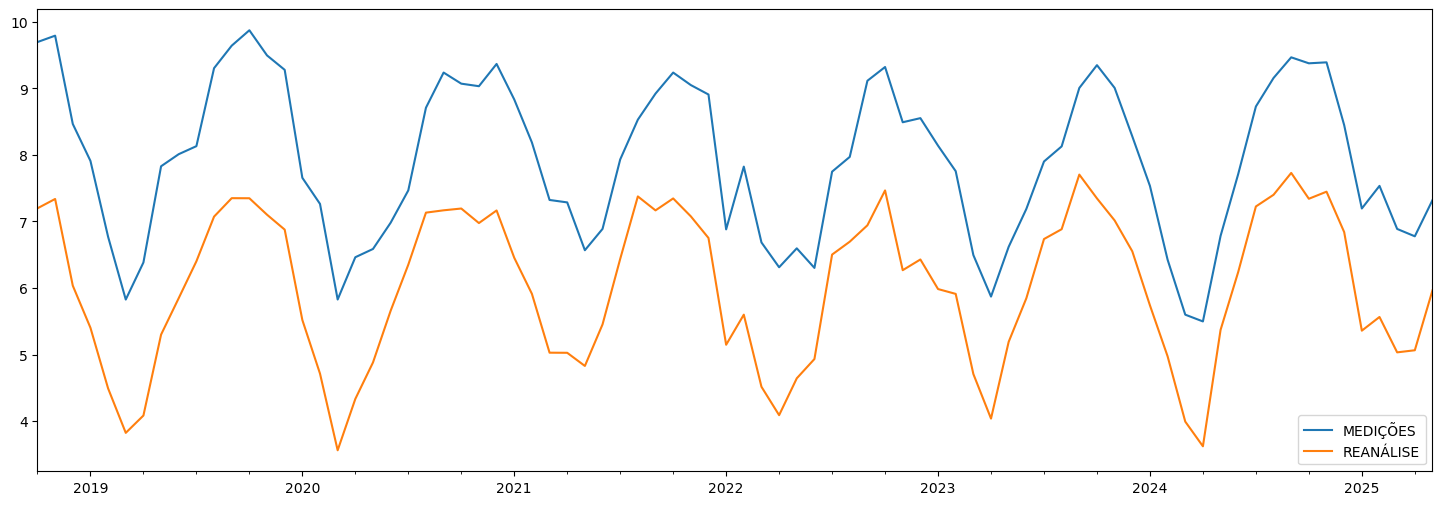

In [27]:
# Concatenar dados de vento de medições e de reanálises
df_vento = pd.concat([df_vento_mensal["WSP"],df_meteo_mensal["wind_speed_100m (m/s)"]],axis=1).dropna()

# Renomear colunas para nomes mais sugestivos
df_vento.columns = ["MEDIÇÕES", "REANÁLISE"]

# Visualizar dados (gráfico de linha)
df_vento.plot(figsize=(18,6))

# Calcular correlação
print(df_vento.corr())

In [6]:
# Exportar para Excel
df_vento.to_excel(r"data\dados_para_extrapolacao.xlsx")

Equação: y = 0.973 * x + 2.063
Coeficiente de Correlação R: 0.944


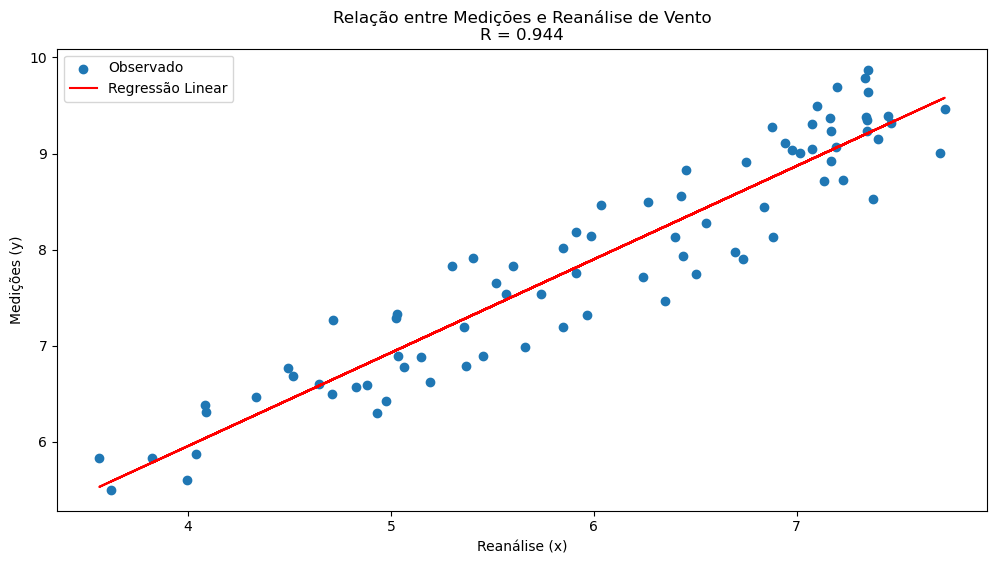

In [28]:
# Definir X e y
df_regressao = df_vento.copy()
X = df_regressao[["REANÁLISE"]].values
y = df_regressao["MEDIÇÕES"].values

# Criar e ajustar modelo de regressão linear
regressao = LinearRegression()
regressao.fit(X, y)

# Previsões
df_regressao["PREV_MEDIÇÕES"] = regressao.predict(X)

# Métrica de correlação R
r_value, _ = pearsonr(df_regressao["REANÁLISE"], df_regressao["MEDIÇÕES"])

# Mostrar equação e correlação
print(f"Equação: y = {regressao.coef_[0]:.3f} * x + {regressao.intercept_:.3f}")
print(f"Coeficiente de Correlação R: {r_value:.3f}")

# Plotagem
plt.figure(figsize=(12, 6))
plt.scatter(df_regressao["REANÁLISE"], df_regressao["MEDIÇÕES"], label="Observado")
plt.plot(
    df_regressao["REANÁLISE"],
    df_regressao["PREV_MEDIÇÕES"],
    color="red",
    label="Regressão Linear",
)
plt.xlabel("Reanálise (x)")
plt.ylabel("Medições (y)")
plt.legend()
plt.title(f"Relação entre Medições e Reanálise de Vento\nR = {r_value:.3f}")
plt.show()

In [16]:
df_vento

,MEDIÇÕES,REANÁLISE
2018-10-01,9.695691,7.198132
2018-11-01,9.791519,7.338375
2018-12-01,8.465055,6.036089
2019-01-01,7.910039,5.403414
2019-02-01,6.769769,4.492262
...,...,...
2025-01-01,7.195318,5.359933
2025-02-01,7.535152,5.565625
2025-03-01,6.888068,5.034046
2025-04-01,6.777612,5.065611


           MEDIÇÕES  REANÁLISE  CORRIGIDO
MEDIÇÕES   1.000000   0.944378   0.944378
REANÁLISE  0.944378   1.000000   1.000000
CORRIGIDO  0.944378   1.000000   1.000000
MEDIÇÕES     7.913918
REANÁLISE    6.016213
CORRIGIDO    7.913867
dtype: float64


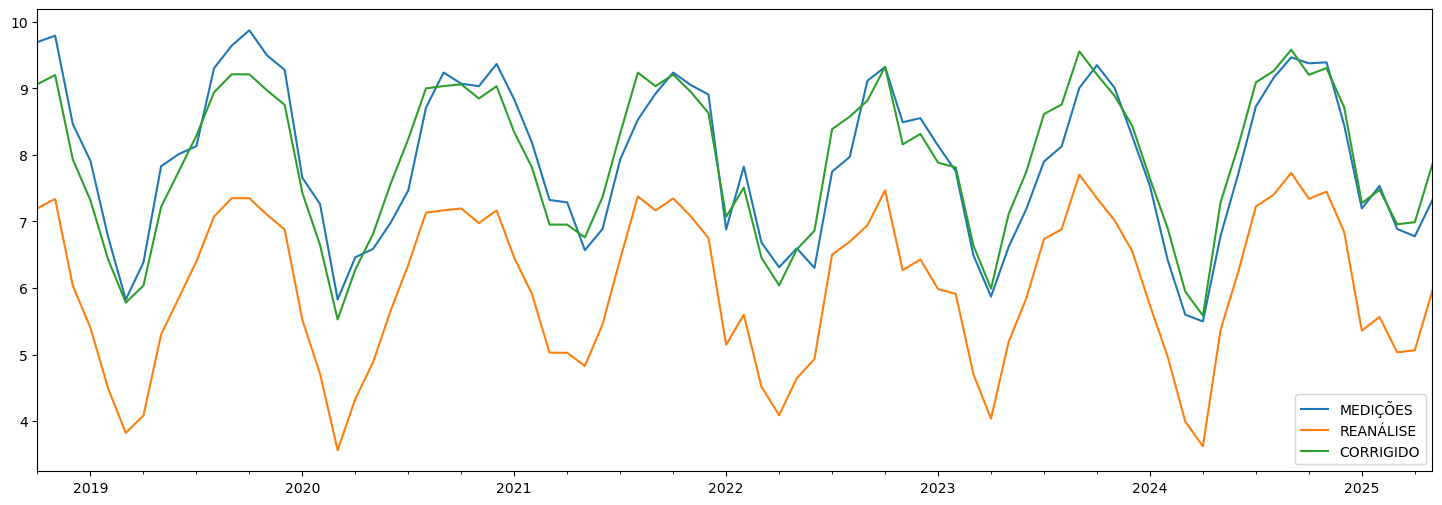

In [29]:
# Corrigir valores com base na regressão
df_vento["CORRIGIDO"] = 0.9725 * df_vento["REANÁLISE"] + 2.0631

# Visualizar e comparar dados (gráfico de linha)
df_vento.plot(figsize=(18,6))

# Comparar valores médios
print(df_vento.corr())
print(df_vento.mean())

- *Dados pré-processados*

In [30]:
# Criando DataFrame pré-processado (dados meteorológicos + vento corrigido)
df_preprocessado = df_meteo_mensal.copy()
# y = 0.973 * x + 2.063
# Aplicando correção de longo prazo nos dados de vento
df_preprocessado["wind_speed (m/s)"] = 0.973 * df_preprocessado["wind_speed_100m (m/s)"] + 2.063
df_preprocessado = df_preprocessado.drop(columns=["wind_speed_100m (m/s)"])
# Visualizar os dados
df_preprocessado.head()

,temperature_2m (°C),relative_humidity_2m (%),surface_pressure (hPa),cloud_cover (%),shortwave_radiation (W/m²),boundary_layer_height (m),wind_gusts_10m (m/s),wind_speed (m/s)
time,,,,,,,,
1991-01-01,27.470161,69.564516,986.899462,67.956989,247.194892,852.620968,8.357930,8.041876
1991-02-01,26.574554,76.562500,987.321577,61.066964,237.406250,712.008929,6.932887,7.377057
1991-03-01,26.214113,78.604839,986.309946,68.065860,220.802419,668.844086,6.644489,6.984418
1991-04-01,26.033889,80.230556,987.039583,57.175000,231.976389,600.569444,5.911528,6.652979
1991-05-01,25.898118,78.829301,987.351075,63.651882,195.427419,604.932796,5.933333,6.691420


- *Análise de features*

In [31]:
# Adicionando variáveis cíclicas (mês)
df_preprocessado["month"] = df_preprocessado.index.month
df_preprocessado["month_sin"] = np.sin(2 * np.pi * df_preprocessado["month"] / 12)
df_preprocessado["month_cos"] = np.cos(2 * np.pi * df_preprocessado["month"] / 12)

# Remover coluna de mês (deixar apenas seno e cosseno do mês)
df_preprocessado = df_preprocessado.drop(columns=["month"])
df_preprocessado.head(12)

,temperature_2m (°C),relative_humidity_2m (%),surface_pressure (hPa),cloud_cover (%),shortwave_radiation (W/m²),boundary_layer_height (m),wind_gusts_10m (m/s),wind_speed (m/s),month_sin,month_cos
time,,,,,,,,,,
1991-01-01,27.470161,69.564516,986.899462,67.956989,247.194892,852.620968,8.357930,8.041876,5.000000e-01,8.660254e-01
1991-02-01,26.574554,76.562500,987.321577,61.066964,237.406250,712.008929,6.932887,7.377057,8.660254e-01,5.000000e-01
1991-03-01,26.214113,78.604839,986.309946,68.065860,220.802419,668.844086,6.644489,6.984418,1.000000e+00,6.123234e-17
1991-04-01,26.033889,80.230556,987.039583,57.175000,231.976389,600.569444,5.911528,6.652979,8.660254e-01,-5.000000e-01
1991-05-01,25.898118,78.829301,987.351075,63.651882,195.427419,604.932796,5.933333,6.691420,5.000000e-01,-8.660254e-01
1991-06-01,26.565972,65.637500,988.868611,36.856944,207.293056,875.048611,7.554583,8.097654,1.224647e-16,-1.000000e+00
1991-07-01,26.123387,60.090054,990.190323,31.709677,210.625000,1063.501344,8.670833,8.890321,-5.000000e-01,-8.660254e-01
1991-08-01,26.220968,56.973118,990.948790,25.057796,234.240591,1149.119624,9.296909,9.290298,-8.660254e-01,-5.000000e-01
1991-09-01,26.966806,57.695833,989.103611,27.829167,266.320833,1115.659722,9.786806,9.447651,-1.000000e+00,-1.836970e-16


<Axes: xlabel='time'>

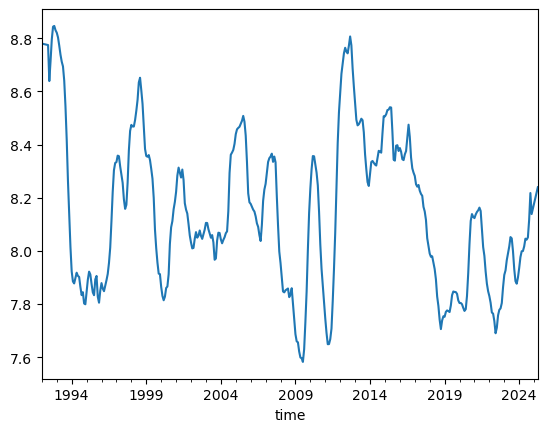

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_preprocessado["wind_speed (m/s)"], extrapolate_trend="freq", period=12)
decomposition.trend.plot()


In [35]:
monthly_mean = df_preprocessado["wind_speed (m/s)"].groupby(df_preprocessado.index.month).mean()
monthly_mean

time
1     7.867306
2     7.507612
3     6.874119
4     6.641661
5     7.185550
6     7.829053
7     8.485218
8     8.957387
9     9.293177
10    9.326302
11    9.137102
12    8.730577
Name: wind_speed (m/s), dtype: float64

In [36]:
# Add Lagged Features
for column in df_preprocessado.columns:
    if column not in ["month_sin", "month_cos"]:
        for lag in [1, 3, 12]:
            df_preprocessado[f"{column} - lag - {lag}"] = df_preprocessado[column].shift(lag)

In [12]:
df_preprocessado

,temperature_2m (°C),relative_humidity_2m (%),surface_pressure (hPa),cloud_cover (%),shortwave_radiation (W/m²),boundary_layer_height (m),wind_gusts_10m (m/s),wind_speed (m/s),month_sin,month_cos,...,shortwave_radiation (W/m²) - lag - 12,boundary_layer_height (m) - lag - 1,boundary_layer_height (m) - lag - 3,boundary_layer_height (m) - lag - 12,wind_gusts_10m (m/s) - lag - 1,wind_gusts_10m (m/s) - lag - 3,wind_gusts_10m (m/s) - lag - 12,wind_speed (m/s) - lag - 1,wind_speed (m/s) - lag - 3,wind_speed (m/s) - lag - 12
time,,,,,,,,,,,,,,,,,,,,,
1991-01-01,27.470161,69.564516,986.899462,67.956989,247.194892,852.620968,8.357930,8.041876,0.500000,8.660254e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-01,26.574554,76.562500,987.321577,61.066964,237.406250,712.008929,6.932887,7.377057,0.866025,5.000000e-01,...,NaN,852.620968,NaN,NaN,8.357930,NaN,NaN,8.041876,NaN,NaN
1991-03-01,26.214113,78.604839,986.309946,68.065860,220.802419,668.844086,6.644489,6.984418,1.000000,6.123234e-17,...,NaN,712.008929,NaN,NaN,6.932887,NaN,NaN,7.377057,NaN,NaN
1991-04-01,26.033889,80.230556,987.039583,57.175000,231.976389,600.569444,5.911528,6.652979,0.866025,-5.000000e-01,...,NaN,668.844086,852.620968,NaN,6.644489,8.357930,NaN,6.984418,8.041876,NaN
1991-05-01,25.898118,78.829301,987.351075,63.651882,195.427419,604.932796,5.933333,6.691420,0.500000,-8.660254e-01,...,NaN,600.569444,712.008929,NaN,5.911528,6.932887,NaN,6.652979,7.377057,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01,27.575941,72.633065,986.965188,55.797043,236.379032,780.443548,6.752957,7.278215,0.500000,8.660254e-01,...,252.010753,1013.219086,1077.735215,913.898697,8.713306,9.430108,7.416263,8.719013,9.206232,7.648098
2025-02-01,27.209673,72.388393,986.508036,62.474702,253.754464,833.772321,6.658780,7.478353,0.866025,5.000000e-01,...,230.790230,780.443548,1089.458333,858.377691,6.752957,9.561528,6.694828,7.278215,9.309647,6.903451
2025-03-01,26.552419,78.549731,987.388441,61.631720,241.943548,692.204301,5.868817,6.961126,1.000000,6.123234e-17,...,215.239247,833.772321,1013.219086,806.438685,6.658780,8.713306,4.899731,7.478353,8.719013,5.948984


In [37]:
df_meteo_mensal.rename(columns={"wind_speed_100m (m/s)": "wind_speed (m/s)"},inplace=True)

In [38]:
for column in df_meteo_mensal.columns:
    df_preprocessado[f"{column} Diff 1M"] = df_preprocessado[column].diff(1)
    df_preprocessado[f"{column} Diff 12M"] = df_preprocessado[column].diff(12)

In [39]:
for column in df_meteo_mensal.columns:
    for window in [3, 12]:
        df_preprocessado[f"{column}_rolling_mean_{window}"] = df_preprocessado[column].rolling(window).mean()
        df_preprocessado[f"{column}_rolling_std_{window}"] = df_preprocessado[column].rolling(window).std()

In [40]:
# Adicionando variável target (vento 1 mês a frente)
df_preprocessado["TARGET"] = df_preprocessado["wind_speed (m/s)"].shift(-1)

# Removendo valores NaN
df_preprocessado = df_preprocessado.dropna()

# Visualizar dados
df_preprocessado.head()

,temperature_2m (°C),relative_humidity_2m (%),surface_pressure (hPa),cloud_cover (%),shortwave_radiation (W/m²),boundary_layer_height (m),wind_gusts_10m (m/s),wind_speed (m/s),month_sin,month_cos,...,shortwave_radiation (W/m²)_rolling_std_12,boundary_layer_height (m)_rolling_mean_3,boundary_layer_height (m)_rolling_std_3,boundary_layer_height (m)_rolling_mean_12,boundary_layer_height (m)_rolling_std_12,wind_gusts_10m (m/s)_rolling_mean_3,wind_gusts_10m (m/s)_rolling_std_3,wind_gusts_10m (m/s)_rolling_mean_12,wind_gusts_10m (m/s)_rolling_std_12,TARGET
time,,,,,,,,,,,,,,,,,,,,,
1992-01-01,26.985215,71.795699,986.417876,64.483871,229.033602,814.522849,8.208468,8.022259,0.500000,8.660254e-01,...,26.804316,929.145311,100.088759,891.512393,207.143965,9.124879,0.808758,8.143679,1.495658,7.448765
1992-02-01,25.860920,79.972701,987.421264,68.079023,229.150862,655.495690,6.974425,7.448765,0.866025,5.000000e-01,...,26.898808,814.555911,159.076755,886.802956,212.177261,8.203437,1.226505,8.147141,1.492646,7.419378
1992-03-01,26.377957,77.126344,986.807661,63.270161,231.435484,729.294355,7.066801,7.419378,1.000000,6.123234e-17,...,26.513709,733.104298,79.582009,891.840479,207.191054,7.416565,0.687362,8.182333,1.458587,7.828768
1992-04-01,26.640417,74.563889,986.491806,50.959722,231.348611,751.340278,7.398889,7.828768,0.866025,-5.000000e-01,...,26.525572,712.043441,50.197030,904.404715,191.931956,7.146705,0.223228,8.306280,1.302972,8.443447
1992-05-01,27.561022,63.946237,987.158602,27.849462,234.116935,960.396505,8.446909,8.443447,0.500000,-8.660254e-01,...,23.126958,813.677046,127.540015,934.026691,167.369690,7.637533,0.720338,8.515745,1.067602,8.500395


In [41]:
df_preprocessado["TARGET_TS"] = df_preprocessado.index + pd.DateOffset(
    months=1
)
df_preprocessado["TARGET_MONTH"] = df_preprocessado["TARGET_TS"].apply(lambda x: x.month)
df_preprocessado["TARGET_CLIMATOLOGY"] = df_preprocessado.apply(
    lambda x: monthly_mean.loc[x["TARGET_MONTH"]], axis=1)

In [43]:
monthly_mean

time
1     7.867306
2     7.507612
3     6.874119
4     6.641661
5     7.185550
6     7.829053
7     8.485218
8     8.957387
9     9.293177
10    9.326302
11    9.137102
12    8.730577
Name: wind_speed (m/s), dtype: float64

In [47]:
df_preprocessado["trend"] = decomposition.trend 
df_preprocessado["TARGET_CLIMATOLOGY_more_Trend"] = df_preprocessado["TARGET_CLIMATOLOGY"] + df_preprocessado["trend"]
df_preprocessado.drop(columns=["TARGET_MONTH","TARGET_CLIMATOLOGY", "TARGET_TS", "trend"], inplace=True)
df_preprocessado

,temperature_2m (°C),relative_humidity_2m (%),surface_pressure (hPa),cloud_cover (%),shortwave_radiation (W/m²),boundary_layer_height (m),wind_gusts_10m (m/s),wind_speed (m/s),month_sin,month_cos,...,boundary_layer_height (m)_rolling_mean_3,boundary_layer_height (m)_rolling_std_3,boundary_layer_height (m)_rolling_mean_12,boundary_layer_height (m)_rolling_std_12,wind_gusts_10m (m/s)_rolling_mean_3,wind_gusts_10m (m/s)_rolling_std_3,wind_gusts_10m (m/s)_rolling_mean_12,wind_gusts_10m (m/s)_rolling_std_12,TARGET,TARGET_CLIMATOLOGY_more_Trend
time,,,,,,,,,,,,,,,,,,,,,
1992-01-01,26.985215,71.795699,986.417876,64.483871,229.033602,814.522849,8.208468,8.022259,5.000000e-01,8.660254e-01,...,929.145311,100.088759,891.512393,207.143965,9.124879,0.808758,8.143679,1.495658,7.448765,16.287192
1992-02-01,25.860920,79.972701,987.421264,68.079023,229.150862,655.495690,6.974425,7.448765,8.660254e-01,5.000000e-01,...,814.555911,159.076755,886.802956,212.177261,8.203437,1.226505,8.147141,1.492646,7.419378,15.652614
1992-03-01,26.377957,77.126344,986.807661,63.270161,231.435484,729.294355,7.066801,7.419378,1.000000e+00,6.123234e-17,...,733.104298,79.582009,891.840479,207.191054,7.416565,0.687362,8.182333,1.458587,7.828768,15.419071
1992-04-01,26.640417,74.563889,986.491806,50.959722,231.348611,751.340278,7.398889,7.828768,8.660254e-01,-5.000000e-01,...,712.043441,50.197030,904.404715,191.931956,7.146705,0.223228,8.306280,1.302972,8.443447,15.961874
1992-05-01,27.561022,63.946237,987.158602,27.849462,234.116935,960.396505,8.446909,8.443447,5.000000e-01,-8.660254e-01,...,813.677046,127.540015,934.026691,167.369690,7.637533,0.720338,8.515745,1.067602,8.500395,16.604292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01,28.195161,64.150538,986.782258,42.395161,269.448925,1013.219086,8.713306,8.719013,-2.449294e-16,1.000000e+00,...,1060.137545,41.053188,937.038295,187.511201,9.234981,0.456537,7.620394,1.801269,7.278215,16.026092
2025-01-01,27.575941,72.633065,986.965188,55.797043,236.379032,780.443548,6.752957,7.278215,5.000000e-01,8.660254e-01,...,961.040323,160.979818,925.917032,192.888861,8.342597,1.440516,7.565118,1.818201,7.478353,15.686582
2025-02-01,27.209673,72.388393,986.508036,62.474702,253.754464,833.772321,6.658780,7.478353,8.660254e-01,5.000000e-01,...,875.811652,121.949136,923.866585,193.800711,7.375014,1.159951,7.562114,1.819799,6.961126,15.073272


In [50]:
wind_speed_columns = [col for col in df_preprocessado.columns if "wind_speed" in col]
wind_speed_columns
df_preprocessado.drop(columns=wind_speed_columns, inplace=True)
df_preprocessado

,temperature_2m (°C),relative_humidity_2m (%),surface_pressure (hPa),cloud_cover (%),shortwave_radiation (W/m²),boundary_layer_height (m),wind_gusts_10m (m/s),month_sin,month_cos,temperature_2m (°C) - lag - 1,...,boundary_layer_height (m)_rolling_mean_3,boundary_layer_height (m)_rolling_std_3,boundary_layer_height (m)_rolling_mean_12,boundary_layer_height (m)_rolling_std_12,wind_gusts_10m (m/s)_rolling_mean_3,wind_gusts_10m (m/s)_rolling_std_3,wind_gusts_10m (m/s)_rolling_mean_12,wind_gusts_10m (m/s)_rolling_std_12,TARGET,TARGET_CLIMATOLOGY_more_Trend
time,,,,,,,,,,,,,,,,,,,,,
1992-01-01,26.985215,71.795699,986.417876,64.483871,229.033602,814.522849,8.208468,5.000000e-01,8.660254e-01,27.305780,...,929.145311,100.088759,891.512393,207.143965,9.124879,0.808758,8.143679,1.495658,7.448765,16.287192
1992-02-01,25.860920,79.972701,987.421264,68.079023,229.150862,655.495690,6.974425,8.660254e-01,5.000000e-01,26.985215,...,814.555911,159.076755,886.802956,212.177261,8.203437,1.226505,8.147141,1.492646,7.419378,15.652614
1992-03-01,26.377957,77.126344,986.807661,63.270161,231.435484,729.294355,7.066801,1.000000e+00,6.123234e-17,25.860920,...,733.104298,79.582009,891.840479,207.191054,7.416565,0.687362,8.182333,1.458587,7.828768,15.419071
1992-04-01,26.640417,74.563889,986.491806,50.959722,231.348611,751.340278,7.398889,8.660254e-01,-5.000000e-01,26.377957,...,712.043441,50.197030,904.404715,191.931956,7.146705,0.223228,8.306280,1.302972,8.443447,15.961874
1992-05-01,27.561022,63.946237,987.158602,27.849462,234.116935,960.396505,8.446909,5.000000e-01,-8.660254e-01,26.640417,...,813.677046,127.540015,934.026691,167.369690,7.637533,0.720338,8.515745,1.067602,8.500395,16.604292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01,28.195161,64.150538,986.782258,42.395161,269.448925,1013.219086,8.713306,-2.449294e-16,1.000000e+00,27.950972,...,1060.137545,41.053188,937.038295,187.511201,9.234981,0.456537,7.620394,1.801269,7.278215,16.026092
2025-01-01,27.575941,72.633065,986.965188,55.797043,236.379032,780.443548,6.752957,5.000000e-01,8.660254e-01,28.195161,...,961.040323,160.979818,925.917032,192.888861,8.342597,1.440516,7.565118,1.818201,7.478353,15.686582
2025-02-01,27.209673,72.388393,986.508036,62.474702,253.754464,833.772321,6.658780,8.660254e-01,5.000000e-01,27.575941,...,875.811652,121.949136,923.866585,193.800711,7.375014,1.159951,7.562114,1.819799,6.961126,15.073272


In [51]:
# Exportar dados para um arquivo csv
df_preprocessado.to_csv("data/dados_preprocessados_new2.csv")

In [ ]:
# plt.figure(figsize=(12, 6))
# sns.heatmap(df_preprocessado.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm")
# plt.show()